<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.Подготовка-данных" data-toc-modified-id="1.Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#2.Исследование-задачи" data-toc-modified-id="2.Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#3.Борьба-с-дисбалансом" data-toc-modified-id="3.Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## 1.Подготовка данных

In [1]:
#импорт библиотек
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import math
import warnings
warnings.filterwarnings("ignore")
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import math
from tqdm import tqdm
from sklearn.metrics import precision_recall_curve
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import pydot
from IPython.display import Image
from sklearn.model_selection import GridSearchCV

In [2]:
# чтение и сохранение данных
churn = pd.read_csv(r'C:\\dataset_praktikum/churn.csv')

In [3]:
churn.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Опишем данные.

Признаки  
**RowNumber** — индекс строки в данных  
**CustomerId** — уникальный идентификатор клиента  
**Surname** — фамилия  
**CreditScore** — кредитный рейтинг  
**Geography** — страна проживания  
**Gender** — пол  
**Age** — возраст  
**Tenure** — сколько лет человек является клиентом банка  
**Balance** — баланс на счёте  
**NumOfProducts** — количество продуктов банка, используемых клиентом  
**HasCrCard** — наличие кредитной карты  
**IsActiveMember** — активность клиента  
**EstimatedSalary** — предполагаемая зарплата  

Целевой признак  
**Exited** — факт ухода клиента  

In [4]:
churn.info() # основная информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


<font color="blue">Есть пропущенные значения в столбце Tenure (сколько лет человек является клиентом банка) около 10 %. Чтобы не удалять пропуски и сохранить данные, спрогнозируем эти пропущенные значения.</font>

In [5]:
churn.duplicated().sum() # проверка на дубликаты

0

In [6]:
churn.describe().T # основная статистическая информация

,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
CreditScore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
Age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
Tenure,9091.0,4.997690e+00,2.894723,0.00,2.00,5.000000e+00,7.000000e+00,10.00
Balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
NumOfProducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
HasCrCard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
IsActiveMember,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
EstimatedSalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48


Посмотрим на распределение признаков.

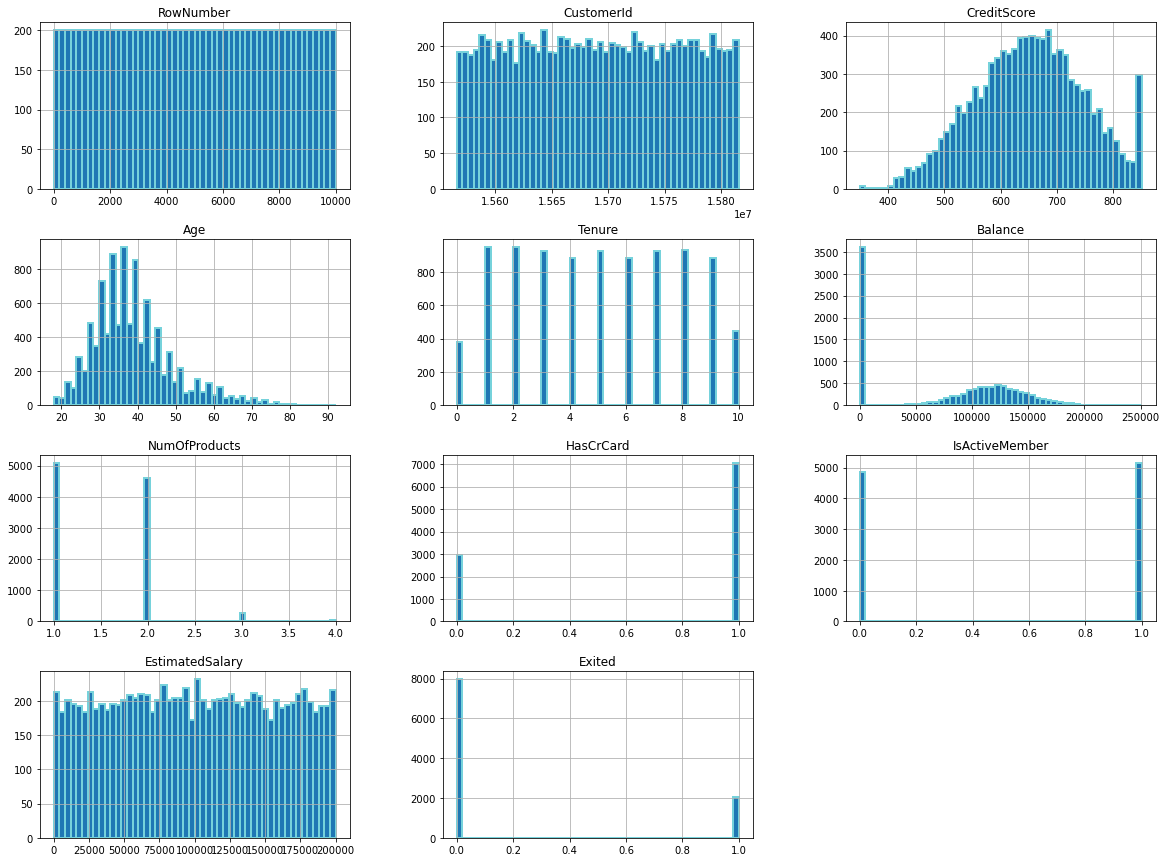

In [7]:
churn.hist(bins=50, figsize=(20,15), edgecolor='#76d2db', linewidth=2)
plt.show()

<font color="blue">В данных отсутствуют аномалии и выбросы. Однако, по балансу можно выделить отдельную большую группу клиентов, у которых нулевой баланс. Также, и по кредитному рейтингу можно выделить отдельную группу клиентов, у которых высокий рейтинг.
</font>

In [8]:
churn['Geography'].value_counts() # количество уникальных значений

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [9]:
churn['Gender'].value_counts() # количество уникальных значений

Male      5457
Female    4543
Name: Gender, dtype: int64

In [10]:
churn['Tenure'].value_counts() # количество уникальных значений

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64

In [11]:
churn['Exited'].value_counts(normalize=True) # количество уникальных значений (доли)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

<font color="blue">Присутствует дисбаланс классов в целевом признаке (80/20).</font>

**Замена пропущенных значений в столбце Tenure.**

Преобразуем категориальные признаки (Geography, Gender) в численные.  
Первым этапом удалим из таблицы лишние столбцы (RowNumber, Surname), которые никак не связаны с Tenure и с Exited.

In [12]:
churn = churn.drop(['RowNumber', 'Surname'], axis=1) # удаление столбцов

In [13]:
churn_dummy = pd.get_dummies(churn, drop_first=True) # кодирование признаков

In [14]:
churn_dummy.head()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,15634602,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,15647311,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,15619304,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,15701354,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,15737888,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


Посомтрим на корреляцию признака Tenure c другими данными.

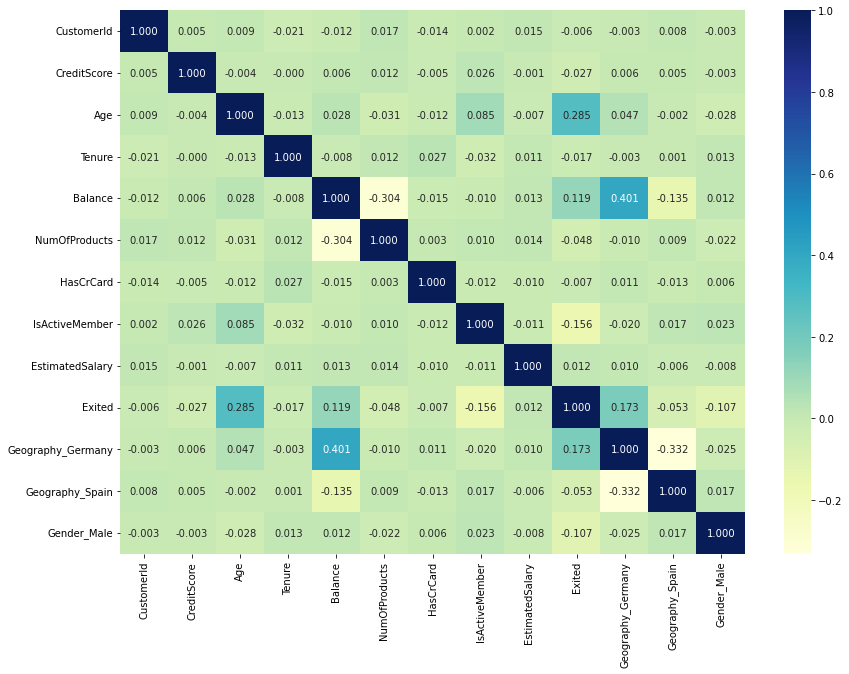

In [15]:
plt.figure(figsize=(14, 10))
sns.heatmap(churn_dummy.corr(), annot = True, fmt = '0.3f', cmap="YlGnBu")
plt.show()

Признак Tenure (сколько лет человек является клиентом банка) явно не коррелирует с другими признаками.

Для построения моделей cформируем новый датасет.

In [16]:
churn_dummy_not_isna_tenure = churn_dummy[~churn_dummy['Tenure'].isna()]

In [17]:
churn_dummy_not_isna_tenure.head()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,15634602,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,15647311,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,15619304,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,15701354,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,15737888,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


Рассчитаем алгоритмы линейной регрессии, случайного леса, дерева решений со стандартными параметрами и выберем лучшую модель.

In [18]:
# определим модели
model_LR = LinearRegression()
model_DTR = DecisionTreeRegressor(random_state=0)
model_rf = RandomForestRegressor(random_state=0)
models = [model_LR, model_DTR, model_rf]
models_name = ['model_LR', 'model_DTR', 'model_rf']

In [19]:
features_tenure = churn_dummy_not_isna_tenure.drop(['Tenure'], axis=1) # извлечем признаки 
target_tenure = churn_dummy_not_isna_tenure['Tenure'] # извлечем зависимую переменную

features_tenure_train_valid, features_tenure_test, target_tenure_train_valid, target_tenure_test = train_test_split(
features_tenure, target_tenure, test_size=0.2, random_state=0, stratify = target_tenure) # отделим 20% данных для тестовой выборки
# отделим 25% (20% от общего количества) данных для валидационной выборки
features_tenure_train, features_tenure_valid, target_tenure_train, target_tenure_valid = train_test_split(
features_tenure_train_valid, target_tenure_train_valid, test_size=0.25, random_state=0, stratify = target_tenure_train_valid)

# стандартизируем данные
scaler_tenure = StandardScaler() # функция стандартизации
scaler_tenure.fit(features_tenure_train) # обучим StandartScaler на обучающей выборке
scaler_tenure.fit(features_tenure_test)

# Преобразуем обучающий, валидационные и тестовые наборы данных
features_tenure_train_st = scaler_tenure.transform(features_tenure_train)
features_tenure_valid_st = scaler_tenure.transform(features_tenure_valid)
features_tenure_test_st = scaler_tenure.transform(features_tenure_test)
features_tenure_st = scaler_tenure.transform(features_tenure)

#Пересчитаем все модели и вычислим метрики RMSE, MAE.

metric_data_tenure = pd.DataFrame()
for m, name_model in zip(models, models_name):
    model_tenure = m # инициализируем модель
    model_tenure.fit(features_tenure_train_st, target_tenure_train) # обучим модель на тренировочной выборке
    predictions_valid_tenure = model_tenure.predict(features_tenure_valid_st) # получим предсказания модели на валидационной выборке
    RMSE_tenure_valid = mean_squared_error(target_tenure_valid, predictions_valid_tenure)**0.5
    MAE_tenure_valid = mean_absolute_error(target_tenure_valid, predictions_valid_tenure)
    
    predictions_test_tenure = model_tenure.predict(features_tenure_test_st) # получим предсказания модели на валидационной выборке
    RMSE_tenure_test = mean_squared_error(target_tenure_test, predictions_test_tenure)**0.5
    MAE_tenure_test = mean_absolute_error(target_tenure_test, predictions_test_tenure)
    
    metric_tenure = pd.DataFrame({'RMSE_valid': RMSE_tenure_valid,
                                 'RMSE_test': RMSE_tenure_test, 
                             'MAE_valid': MAE_tenure_valid,
                              'MAE_test': MAE_tenure_test},
                               index=[name_model])
    metric_data_tenure = metric_data_tenure.append(metric_tenure)

In [20]:
metric_data_tenure

,RMSE_valid,RMSE_test,MAE_valid,MAE_test
model_LR,2.895470,2.885710,2.494038,2.487566
model_DTR,4.095464,4.186420,3.325083,3.405168
model_rf,2.968048,2.934435,2.551018,2.518620


Метрики модели линейной регрессии лучше, но еще попробуем подобрать гиперпараметры у случайного леса. 

In [21]:
model_rf_tenure = RandomForestRegressor(random_state=0, max_depth=4, n_estimators=250)
model_rf_tenure.fit(features_tenure_train_st, target_tenure_train) # обучим модель на тренировочной выборке
predictions_valid_tenure = model_rf_tenure.predict(features_tenure_valid_st) # получим предсказания модели на валидационной выборке
RMSE_tenure_valid = mean_squared_error(target_tenure_valid, predictions_valid_tenure)**0.5
MAE_tenure_valid = mean_absolute_error(target_tenure_valid, predictions_valid_tenure)
    
predictions_test_tenure = model_tenure.predict(features_tenure_test_st) # получим предсказания модели на валидационной выборке
RMSE_tenure_test = mean_squared_error(target_tenure_test, predictions_test_tenure)**0.5
MAE_tenure_test = mean_absolute_error(target_tenure_test, predictions_test_tenure)
    
metric_tenure = pd.DataFrame({'RMSE_valid': RMSE_tenure_valid,
                                 'RMSE_test': RMSE_tenure_test, 
                             'MAE_valid': MAE_tenure_valid,
                              'MAE_test': MAE_tenure_test},
                               index=[name_model])
metric_tenure

,RMSE_valid,RMSE_test,MAE_valid,MAE_test
model_rf,2.893881,2.934435,2.491553,2.51862


Метрики улучшились только на валидационной выборке, все равно модель логистической регрессии немного лучше.

С целью возможного улучшения метрик обучим модель на выборке трейн+валид+тест, и потом спрогнозируем пропущенные Tenure.

In [22]:
churn_dummy_isna_tenure = churn_dummy[churn_dummy['Tenure'].isna()]
features_isna_tenure = churn_dummy_isna_tenure.drop(['Tenure'], axis=1) # извлечем признаки

In [23]:
model_tenure_optimal = model_LR = LinearRegression()
model_tenure_optimal.fit(features_tenure_st, target_tenure) # обучим модель на трейн+валид+тест выборках

# стандартизируем данные
scaler_tenure_optimal = StandardScaler() # функция стандартизации
scaler_tenure_optimal.fit(features_tenure) # обучим StandartScaler на трейн+валид+тест выборках

# Преобразуем features_isna_tenure
features_isna_tenure_st = scaler_tenure_optimal.transform(features_isna_tenure)

In [24]:
# заменим пропущенные значения в столбце Tenure
churn_dummy_isna_tenure['Tenure'] = model_tenure_optimal.predict(features_isna_tenure_st) 

In [25]:
# объеденим датасеты
churn_dummy = pd.concat([churn_dummy_not_isna_tenure, churn_dummy_isna_tenure]).sort_index()

### Вывод по шагу №1 (Подготовка данных)

На данном этапе загружены и предобработаны данные, проведен краткий исследовательский анализ данных.  
Произведена замена пропущенных значений в столбце Tenure с помощью модели линейной регрессии.  
В данных отсутствуют аномалии и выбросы. Однако, по балансу можно выделить отдельную большую группу клиентов, у которых нулевой баланс. Также, и по кредитному рейтингу можно выделить отдельную группу клиентов, у которых высокий рейтинг.  
Присутствует дисбаланс классов в целевом признаке (80/20).  


## 2.Исследование задачи

Перед нами стоит задача классификации - необходимо предсказать вероятность ухода клиентов из банка.  
На первом этапе рассчитаем алгоритмы Логистической регрессии, Случайного леса, Дерева решений со стандартными параметрами на различных датасетах без учета дисбаланса.  
Для оценки окончательной модели будем использовать метрику F1 и кривую ROC с ее площадью (ROC-AUC).  
Как мы выяснили, у нас дисбаланс классов, необходимо это учесть.

Посмотрим на корреляцию признака Exited c другими данными.

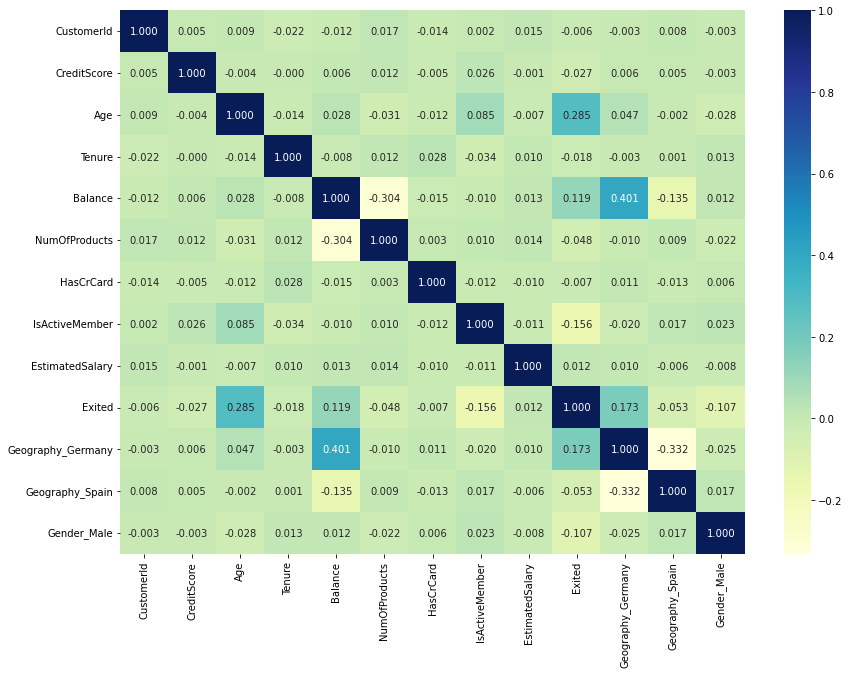

In [26]:
plt.figure(figsize=(14, 10))
sns.heatmap(churn_dummy.corr(), annot = True, fmt = '0.3f', cmap="YlGnBu")
plt.show()

<font color="blue">У признака Exited есть слабая кореляция с Age (0.285), Geography_Germany (0.173), IsActiveMember (-0.156), Balance (0.119), Gender_Male (0.107). Мультиколлинеарных признаков нет.</font>

Разделим и стандартизируем данные.

In [27]:
target = churn_dummy['Exited'] # извлечем признаки
features = churn_dummy.drop('Exited', axis=1) # извлечем зависимую переменную

features_train_valid, features_test, target_train_valid, target_test = train_test_split(
features, target, test_size=0.2, random_state=0, stratify = target) # отделим 20% данных для тестовой выборки
# отделим 25% (20% от общего количества) данных для валидационной выборки
features_train, features_valid, target_train, target_valid = train_test_split(
features_train_valid, target_train_valid, test_size=0.25, random_state=0, stratify = target_train_valid)

# стандартизируем данные
scaler = StandardScaler() # функция стандартизации
scaler.fit(features_train) # обучим StandartScaler на обучающей выборке

# Преобразуем обучающий, валидационные и тестовые наборы данных
features_train_st = scaler.transform(features_train)
features_valid_st = scaler.transform(features_valid)
features_test_st = scaler.transform(features_test)
features_train_valid_st = scaler.transform(features_train_valid)

Напишем функцию для подсчета метрик.

In [28]:
def metric(m, name_model, f_train, t_train, f_valid, t_valid, f_test, t_test):
    model = m
    model.fit(f_train, t_train) # обучим модель на тренировочной выборке
    
    predicted_train = model.predict(features_train_st) # получим предсказания модели на обучающей выборке
    probabilities_train = model.predict_proba(features_train_st) # значения вероятностей классов
    probabilities_one_train = probabilities_train[:, 1] # значения вероятностей класса «1»
    
    predicted_valid = model.predict(f_valid) # получим предсказания модели на валидационной выборке
    probabilities_valid = model.predict_proba(f_valid) # значения вероятностей классов
    probabilities_one_valid = probabilities_valid[:, 1] # значения вероятностей класса «1»
    
    predicted_test = model.predict(f_test) # получим предсказания модели на тестовой выборке
    probabilities_test = model.predict_proba(f_test) # значения вероятностей классов
    probabilities_one_test = probabilities_test[:, 1] # значения вероятностей класса «1»
    
    precision_tr = round(precision_score(target_train, predicted_train),3)
    recall_tr = round(recall_score(target_train, predicted_train),3)
    f1_tr = round(f1_score(target_train, predicted_train),3)
    auc_roc_tr = round(roc_auc_score(target_train, predicted_train),3)
    
    precision_v = round(precision_score(t_valid, predicted_valid),3)
    recall_v = round(recall_score(t_valid, predicted_valid),3)
    f1_v = round(f1_score(t_valid, predicted_valid),3)
    auc_roc_v = round(roc_auc_score(t_valid, probabilities_one_valid),3)
    
    precision_t = round(precision_score(t_test, predicted_test),3)
    recall_t = round(recall_score(t_test, predicted_test),3)
    f1_t = round(f1_score(t_test, predicted_test),3)
    auc_roc_t = round(roc_auc_score(t_test, probabilities_one_test),3)
    
    metric_data = pd.DataFrame({'precision_tr': precision_tr,
                            'precision_v': precision_v,
                           'precision_t': precision_t,
                              'recall_tr': recall_tr,  
                             'recall_v': recall_v,
                           'recall_t': recall_t,
                                'f1_tr': f1_tr,
                             'f1_v': f1_v,
                           'f1_t': f1_t,
                              'auc_roc_tr': auc_roc_tr,  
                             'auc_roc_v': auc_roc_v,
                          'auc_roc_t': auc_roc_t},
                               index=[name_model])
    return metric_data

In [29]:
# определим модели
lr_model_1 = LogisticRegression(random_state=0, solver='liblinear')
rf_model_1 = RandomForestClassifier(random_state=0)
dt_model_1 = DecisionTreeClassifier(random_state=0)
models_1 = [lr_model_1, rf_model_1, dt_model_1]
models_name_1 = ['lr_model_1', 'rf_model_1', 'dt_model_1']

Пересчитаем все модели с дефолтными параметрами и сравним метрики.

In [30]:
metric_data_1 = pd.DataFrame()

for m, name_model in tqdm(zip(models_1, models_name_1)):
    metric_data_1 = metric_data_1.append(metric(m, name_model,
                                                features_train_st, target_train,
                                                features_valid_st, target_valid,
                                                features_test_st, target_test))

metric_data_1.sort_values(['f1_v', 'auc_roc_v'], ascending=False).style.bar(subset=['auc_roc_v'], color='#adc6e9')\
                 .background_gradient(subset=['f1_v'], cmap='Purples')

3it [00:02,  1.05it/s]


,precision_tr,precision_v,precision_t,recall_tr,recall_v,recall_t,f1_tr,f1_v,f1_t,auc_roc_tr,auc_roc_v,auc_roc_t
rf_model_1,1.000000,0.756000,0.761000,1.000000,0.450000,0.430000,1.000000,0.564000,0.549000,1.000000,0.836000,0.847000
dt_model_1,1.000000,0.495000,0.516000,1.000000,0.467000,0.486000,1.000000,0.480000,0.501000,1.000000,0.673000,0.685000
lr_model_1,0.582000,0.608000,0.583000,0.213000,0.214000,0.216000,0.311000,0.316000,0.315000,0.587000,0.763000,0.766000


<font color="blue">Наибольшая метрика F1 у случайного леса на валидационной выборке = 0.568, но эта модель переобучена. </font>

Подберем лучшие параметры для этой модели (n_estimators и max_depth).

In [31]:
metric(RandomForestClassifier(random_state = 0, max_depth=11, n_estimators=70), 'model_rf',
                                                                                features_train_st, target_train,
                                                                                features_valid_st, target_valid,
                                                                                features_test_st, target_test)

,precision_tr,precision_v,precision_t,recall_tr,recall_v,recall_t,f1_tr,f1_v,f1_t,auc_roc_tr,auc_roc_v,auc_roc_t
model_rf,0.965,0.782,0.784,0.639,0.432,0.4,0.769,0.557,0.53,0.817,0.839,0.851


### Вывод по шагу №2 (Исследование задачи)

У признака Exited есть слабая кореляция с Age (0.285), Geography_Germany (0.173), IsActiveMember (-0.156), Balance (0.119), Gender_Male (0.107). Мультиколлинеарных признаков нет.    
Присутствует дисбаланс классов в целевом признаке (80/20).  
Рассчитаны алгоритмы Логистической регрессии, Случайного леса, Дерева решений со стандартными параметрами без учета дисбаланса.  
Модель случайного леса со стандартными параметрами показала себя лучше чем остальные варианты.  
Метрика F1=0.563

## 3.Борьба с дисбалансом

**Вариант №1. Установка параметра class_weight='balanced'.**

In [32]:
# определим модели
lr_model_2 = LogisticRegression(random_state=0, solver='liblinear', class_weight='balanced')
rf_model_2 = RandomForestClassifier(random_state=0, class_weight='balanced')
dt_model_2 = DecisionTreeClassifier(random_state=0, class_weight='balanced')
models_2 = [lr_model_2, rf_model_2, dt_model_2]
models_name_2 = ['lr_model_2', 'rf_model_2', 'dt_model_2']

In [33]:
metric_data_2 = pd.DataFrame()
for m, name_model in tqdm(zip(models_2, models_name_2)):
    metric_data_2 = metric_data_2.append(metric(m, name_model,
                                                features_train_st, target_train,
                                                features_valid_st, target_valid,
                                                features_test_st, target_test))

metric_data_2.sort_values(['f1_v', 'auc_roc_v'], ascending=False).style.bar(subset=['auc_roc_v'], color='#adc6e9')\
                 .background_gradient(subset=['f1_v'], cmap='Purples')

3it [00:02,  1.15it/s]


,precision_tr,precision_v,precision_t,recall_tr,recall_v,recall_t,f1_tr,f1_v,f1_t,auc_roc_tr,auc_roc_v,auc_roc_t
rf_model_2,1.000000,0.792000,0.788000,1.000000,0.413000,0.403000,1.000000,0.543000,0.533000,1.000000,0.846000,0.850000
dt_model_2,1.000000,0.506000,0.492000,1.000000,0.501000,0.479000,1.000000,0.504000,0.486000,1.000000,0.688000,0.676000
lr_model_2,0.393000,0.383000,0.374000,0.710000,0.649000,0.700000,0.506000,0.481000,0.487000,0.715000,0.765000,0.767000


Подберем лучшие параметры для случайного леса (n_estimators и max_depth).

{'max_depth': 8, 'n_estimators': 80}

In [34]:
metric(RandomForestClassifier(random_state = 0, max_depth=8, n_estimators=80, class_weight='balanced'), 'model_rf',
                                                                                features_train_st, target_train,
                                                                                features_valid_st, target_valid,
                                                                                features_test_st, target_test)

,precision_tr,precision_v,precision_t,recall_tr,recall_v,recall_t,f1_tr,f1_v,f1_t,auc_roc_tr,auc_roc_v,auc_roc_t
model_rf,0.668,0.557,0.556,0.797,0.622,0.646,0.727,0.588,0.598,0.848,0.847,0.85


<font color="blue">Метрики моделей с параметром class_weight='balanced' стали лучше. </font>

**Вариант №2. Upsample или downsample.**

In [35]:
def upsample(features, target, repeat):
    '''
    увеличение положительного класса, аргументы:
    features - признаки, target - целевой признак, repeat - количество повторений.
    '''
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=0)
    
    return features_upsampled, target_upsampled

In [36]:
def downsample(features, target, fraction):
    '''
    уменьшение отрицательного класса, аргументы:
    features - признаки, target - целевой признак, fraction - доля отрицательных объектов, которые нужно сохранить.
    '''
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=0)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=0)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=0)
    
    return features_downsampled, target_downsampled

Переберем различные repeat,fraction и вычислим метрики моделей со стандартными параметрами.

In [37]:
metric_data_3 = pd.DataFrame()
for m, name_model in tqdm(zip(models_1, models_name_1)):
    for i in np.arange(1,5,1):
        features_upsampled, target_upsampled = upsample(features_train, target_train, i)
        features_upsampled_st = scaler.transform(features_upsampled)
        metric_data_3 = metric_data_3.append(metric(m, str(i)+'_'+name_model, features_upsampled_st, target_upsampled,
                                                                                  features_valid_st, target_valid,
                                                                                  features_test_st, target_test))
metric_data_3.sort_values(['f1_v', 'auc_roc_v'], ascending=False).style.bar(subset=['auc_roc_v'], color='#adc6e9')\
                 .background_gradient(subset=['f1_v'], cmap='Purples')

3it [00:11,  3.98s/it]


,precision_tr,precision_v,precision_t,recall_tr,recall_v,recall_t,f1_tr,f1_v,f1_t,auc_roc_tr,auc_roc_v,auc_roc_t
4_rf_model_1,1.000000,0.676000,0.686000,1.000000,0.509000,0.521000,1.000000,0.581000,0.592000,1.000000,0.842000,0.848000
3_rf_model_1,1.000000,0.683000,0.679000,1.000000,0.504000,0.504000,1.000000,0.580000,0.578000,1.000000,0.841000,0.841000
2_rf_model_1,1.000000,0.707000,0.690000,1.000000,0.486000,0.504000,1.000000,0.576000,0.582000,1.000000,0.836000,0.852000
1_rf_model_1,1.000000,0.769000,0.763000,1.000000,0.432000,0.435000,1.000000,0.553000,0.554000,1.000000,0.836000,0.846000
2_dt_model_1,1.000000,0.506000,0.497000,1.000000,0.506000,0.484000,1.000000,0.506000,0.491000,1.000000,0.690000,0.680000
3_dt_model_1,1.000000,0.515000,0.495000,1.000000,0.496000,0.479000,1.000000,0.506000,0.487000,1.000000,0.689000,0.677000
4_dt_model_1,1.000000,0.511000,0.497000,1.000000,0.499000,0.462000,1.000000,0.505000,0.479000,1.000000,0.688000,0.671000
4_lr_model_1,0.390000,0.379000,0.374000,0.718000,0.661000,0.710000,0.505000,0.482000,0.490000,0.715000,0.765000,0.767000
1_dt_model_1,1.000000,0.495000,0.516000,1.000000,0.467000,0.486000,1.000000,0.480000,0.501000,1.000000,0.673000,0.685000
3_lr_model_1,0.441000,0.411000,0.413000,0.615000,0.553000,0.592000,0.513000,0.471000,0.486000,0.708000,0.765000,0.767000


Подберем лучшие параметры для случайного леса (n_estimators и max_depth).

In [38]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)
features_upsampled_st = scaler.transform(features_upsampled)

In [39]:
metric(RandomForestClassifier(random_state = 0, n_estimators=80, max_depth=14), 'rf_model',
                                                                                features_upsampled_st, target_upsampled,
                                                                                  features_valid_st, target_valid,
                                                                                  features_test_st, target_test)

,precision_tr,precision_v,precision_t,recall_tr,recall_v,recall_t,f1_tr,f1_v,f1_t,auc_roc_tr,auc_roc_v,auc_roc_t
rf_model,0.949,0.633,0.62,0.998,0.56,0.56,0.973,0.595,0.588,0.992,0.84,0.845


In [40]:
metric_data_4 = pd.DataFrame()
for m, name_model in tqdm(zip(models_1, models_name_1)):
    for i in [0.2,0.3,0.4,0.5,0.6,0.7]:
        features_downsampled, target_downsampled = downsample(features_train, target_train, i)
        features_downsampled_st = scaler.transform(features_downsampled)
        metric_data_4 = metric_data_4.append(metric(m, str(i)+'_'+name_model, features_downsampled_st, target_downsampled,
                                                                                  features_valid_st, target_valid,
                                                                                  features_test_st, target_test))
metric_data_4.sort_values(['f1_v', 'auc_roc_v'], ascending=False).style.bar(subset=['auc_roc_v'], color='#adc6e9')\
                 .background_gradient(subset=['f1_v'], cmap='Purples')

3it [00:11,  3.97s/it]


,precision_tr,precision_v,precision_t,recall_tr,recall_v,recall_t,f1_tr,f1_v,f1_t,auc_roc_tr,auc_roc_v,auc_roc_t
0.4_rf_model_1,0.789000,0.578000,0.572000,1.000000,0.602000,0.604000,0.882000,0.590000,0.588000,0.966000,0.838000,0.841000
0.7_rf_model_1,0.938000,0.701000,0.689000,1.000000,0.501000,0.506000,0.968000,0.585000,0.584000,0.992000,0.838000,0.844000
0.3_rf_model_1,0.691000,0.514000,0.510000,1.000000,0.676000,0.683000,0.817000,0.584000,0.584000,0.943000,0.841000,0.845000
0.6_rf_model_1,0.895000,0.643000,0.645000,1.000000,0.531000,0.536000,0.945000,0.581000,0.585000,0.985000,0.844000,0.842000
0.5_rf_model_1,0.856000,0.620000,0.626000,0.999000,0.545000,0.568000,0.922000,0.580000,0.595000,0.978000,0.841000,0.843000
0.2_rf_model_1,0.555000,0.433000,0.421000,1.000000,0.767000,0.769000,0.714000,0.553000,0.544000,0.897000,0.840000,0.839000
0.7_dt_model_1,0.841000,0.481000,0.452000,1.000000,0.545000,0.572000,0.913000,0.511000,0.505000,0.976000,0.697000,0.697000
0.4_dt_model_1,0.638000,0.414000,0.420000,1.000000,0.629000,0.629000,0.779000,0.499000,0.503000,0.927000,0.701000,0.703000
0.5_dt_model_1,0.714000,0.426000,0.422000,1.000000,0.577000,0.614000,0.833000,0.490000,0.501000,0.949000,0.689000,0.700000
0.3_dt_model_1,0.573000,0.382000,0.373000,1.000000,0.656000,0.663000,0.729000,0.483000,0.477000,0.905000,0.692000,0.689000


Подберем лучшие параметры для случайного леса (n_estimators и max_depth).

In [41]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.4)
features_downsampled_st = scaler.transform(features_downsampled)

In [42]:
metric(RandomForestClassifier(random_state = 0, n_estimators=50, max_depth=13), 'rf_model',
                                                                                features_downsampled_st, target_downsampled,
                                                                                  features_valid_st, target_valid,
                                                                                  features_test_st, target_test)

,precision_tr,precision_v,precision_t,recall_tr,recall_v,recall_t,f1_tr,f1_v,f1_t,auc_roc_tr,auc_roc_v,auc_roc_t
rf_model,0.781,0.574,0.564,0.953,0.612,0.607,0.859,0.592,0.585,0.942,0.841,0.843


<font color="blue">Метрику F1 удалось улучшить до 0.592, путем уменьшения отрицательного класса в 0,4 раза и подбора гиперпараметров случайного леса.<font color="blue">

Сформируем оптимальную модель.

In [43]:
model = RandomForestClassifier(random_state = 0, n_estimators=50, max_depth=13)

model.fit(features_downsampled_st, target_downsampled) # обучим модель на тренировочной выборке

predicted_valid = model.predict(features_valid_st) # получим предсказания модели на валидационной выборке
probabilities_valid = model.predict_proba(features_valid_st) # значения вероятностей классов
probabilities_one_valid = probabilities_valid[:, 1] # значения вероятностей класса «1»

In [44]:
metric(model, 'rf_model', features_downsampled_st, target_downsampled,features_valid_st, target_valid,features_test_st, target_test)

,precision_tr,precision_v,precision_t,recall_tr,recall_v,recall_t,f1_tr,f1_v,f1_t,auc_roc_tr,auc_roc_v,auc_roc_t
rf_model,0.781,0.574,0.564,0.953,0.612,0.607,0.859,0.592,0.585,0.942,0.841,0.843


Отобразим ROC-кривую

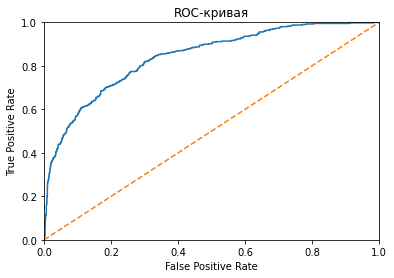

In [45]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()

plt.plot(fpr, tpr)
# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Отобразим PR-кривую.

Text(0.5, 0, 'Recall')

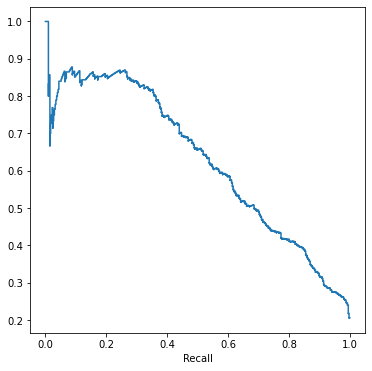

In [46]:
precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')

Посмотрим на зависимость метрик от порога вероятности классификации.

In [47]:
metric_data_5 = pd.DataFrame()
for threshold in np.arange(0.1, 0.8, 0.01):
    
    predicted_valid = probabilities_one_valid > threshold
    precision =  round(precision_score(target_valid, predicted_valid),3)
    recall = round(recall_score(target_valid, predicted_valid),3)
    f1 = round(f1_score(target_valid, predicted_valid),3)
    auc_roc = round(roc_auc_score(target_valid, predicted_valid),3)
    metric_data = pd.DataFrame({'precision_v': precision,
                                'recall_v': recall,
                                 'f1_v': f1,
                                 'auc_roc_v': auc_roc,},
                               index=[threshold])
    metric_data_5 = metric_data_5.append(metric_data)
    ##print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}".format(
        #threshold, precision, recall))
metric_data_5.sort_values(['f1_v', 'auc_roc_v'], ascending=False).style.bar(subset=['auc_roc_v'], color='#adc6e9')\
                 .background_gradient(subset=['f1_v'], cmap='Purples')

,precision_v,recall_v,f1_v,auc_roc_v
0.5099999999999998,0.585000,0.602000,0.593000,0.746000
0.4999999999999998,0.574000,0.612000,0.592000,0.748000
0.5199999999999998,0.593000,0.590000,0.591000,0.743000
0.48999999999999977,0.564000,0.614000,0.588000,0.747000
0.4199999999999998,0.508000,0.686000,0.584000,0.758000
0.5299999999999998,0.596000,0.572000,0.584000,0.737000
0.47999999999999976,0.553000,0.617000,0.583000,0.745000
0.5399999999999998,0.606000,0.563000,0.583000,0.735000
0.46999999999999986,0.545000,0.622000,0.581000,0.745000
0.4099999999999998,0.497000,0.693000,0.579000,0.757000


<font color="blue">Метрику F1 можно улучшить до 0.593, если порог вероятности взять 0,51.<font color="blue">

Посомтрим на важность признаков.

In [48]:
feature_imp = pd.Series(model.feature_importances_,index=features.columns).sort_values(ascending=False)
feature_imp

Age                  0.270854
NumOfProducts        0.134695
Balance              0.111881
EstimatedSalary      0.099534
CustomerId           0.099215
CreditScore          0.097472
Tenure               0.067396
IsActiveMember       0.041587
Geography_Germany    0.030491
Gender_Male          0.019776
HasCrCard            0.014817
Geography_Spain      0.012282
dtype: float64

<font color="blue">Самые важные признаки - Age, NumOfProducts, Balance.<font color="blue">

In [49]:
# визуализация одного дерева из модели
#estimator = rf_model_optimal.estimators_[1]
#from sklearn.tree import export_graphviz
#export_graphviz(estimator, out_file='tree.dot', feature_names = features.columns, class_names = 'Exited',
                #rounded = True, proportion = False, precision = 2, filled = True)
#(graph,) = pydot.graph_from_dot_file('tree.dot')
#graph.write_png('tree.png')
#Image(filename = 'tree.png')

Попробуем убрать из датасета клиентов с нулевым балансом, чтобы выровнять распределение баланса.

In [50]:
df1 = churn_dummy.query('Balance >= 1000')
target_df1 = df1['Exited'] # извлечем признаки
features_df1 = df1.drop('Exited', axis=1) # извлечем зависимую переменную

features_train_valid_df1, features_test_df1, target_train_valid_df1, target_test_df1 = train_test_split(
features_df1, target_df1, test_size=0.2, random_state=0, stratify = target_df1) # отделим 20% данных для тестовой выборки
# отделим 25% (20% от общего количества) данных для валидационной выборки
features_train_df1, features_valid_df1, target_train_df1, target_valid_df1 = train_test_split(
features_train_valid_df1, target_train_valid_df1, test_size=0.25, random_state=0, stratify = target_train_valid_df1)

# стандартизируем данные
scaler_df1 = StandardScaler() # функция стандартизации
scaler_df1.fit(features_train_df1) # обучим StandartScaler на обучающей выборке

features_downsampled_df1, target_downsampled_df1 = downsample(features_train_df1, target_train_df1, 0.4)
features_downsampled_st_df1 = scaler_df1.transform(features_downsampled_df1)

# Преобразуем обучающий, валидационные и тестовые наборы данных
features_train_st_df1 = scaler_df1.transform(features_train_df1)
features_valid_st_df1 = scaler_df1.transform(features_valid_df1)
features_test_st_df1 = scaler_df1.transform(features_test_df1)
features_st_df1 = scaler_df1.transform(features_df1)


metric(RandomForestClassifier(random_state = 0, n_estimators=50, max_depth=13), 'rf_model',
                                                                                features_downsampled_st_df1, target_downsampled_df1,
                                                                                  features_valid_st_df1, target_valid_df1,
                                                                                  features_test_st_df1, target_test_df1)

,precision_tr,precision_v,precision_t,recall_tr,recall_v,recall_t,f1_tr,f1_v,f1_t,auc_roc_tr,auc_roc_v,auc_roc_t
rf_model,0.628,0.588,0.584,0.728,0.643,0.671,0.674,0.614,0.624,0.809,0.813,0.833


<font color="blue">На таких отфильтрованных данных метрику F1 можно получить 0,614-0,624.<font color="blue">

### Вывод по шагу №3 (Борьба с дисбалансом)

Компенсация дисбаланса помогла в увеличении метрик.  
Оптимальная модель - RandomForestClassifier(random_state = 0, n_estimators=50, max_depth=13) с компенсацией дисбаланса классов путем уменьшения отрицательного класса в 0,4 раза.  
Метрика F1 на валидационной выборке = 0.592, можно улучшить до 0.593 если взять порог вероятности =0.51.  
Самые важные признаки - Age, NumOfProducts, Balance.

## Тестирование модели

С целью возможного улучшения метрик обучим оптимальную модель на выборке трейн+валид, и потом спрогнозируем отток на тестовой выборке.

In [51]:
features_train_valid_downsampled, target_train_valid_downsampled = downsample(features_train_valid, target_train_valid, 0.4)
features_train_valid_downsampled_st = scaler.transform(features_train_valid_downsampled)

model = RandomForestClassifier(random_state = 0, n_estimators=50, max_depth=13)

model.fit(features_train_valid_downsampled_st, target_train_valid_downsampled) # обучим модель на train_valid выборке

predicted_train_valid = model.predict(features_train_valid_st) # получим предсказания модели на train_valid выборке
probabilities_train_valid = model.predict_proba(features_train_valid_st) # значения вероятностей классов
probabilities_one_train_valid = probabilities_train_valid[:, 1] # значения вероятностей класса «1»
    
predicted_test = model.predict(features_test_st) # получим предсказания модели на тестовой выборке
probabilities_test = model.predict_proba(features_test_st) # значения вероятностей классов
probabilities_one_test = probabilities_test[:, 1] # значения вероятностей класса «1»
    
precision_tr_v = round(precision_score(target_train_valid, predicted_train_valid),3)
recall_tr_v = round(recall_score(target_train_valid, predicted_train_valid),3)
f1_tr_v = round(f1_score(target_train_valid, predicted_train_valid),3)
auc_roc_tr_v = round(roc_auc_score(target_train_valid, probabilities_one_train_valid),3)
    
precision_t = round(precision_score(target_test, predicted_test),3)
recall_t = round(recall_score(target_test, predicted_test),3)
f1_t = round(f1_score(target_test, predicted_test),3)
auc_roc_t = round(roc_auc_score(target_test, probabilities_one_test),3)
    
metric_data = pd.DataFrame({'precision_tr_v': precision_tr_v,
                            'precision_t': precision_t,
                              'recall_tr_v': recall_tr_v,  
                              'recall_t': recall_t,
                                'f1_tr_v': f1_tr_v,
                               'f1_t': f1_t,
                              'auc_roc_tr_v': auc_roc_tr_v,  
                             'auc_roc_t': auc_roc_t},
                               index=['rf_model'])
metric_data

,precision_tr_v,precision_t,recall_tr_v,recall_t,f1_tr_v,f1_t,auc_roc_tr_v,auc_roc_t
rf_model,0.776,0.593,0.933,0.636,0.847,0.614,0.981,0.851


<font color="blue">Метрика F1 на тестовой выборке = 0,614.<font color="blue">

## Общий вывод по проекту

Произведена замена пропущенных значений в столбце Tenure с помощью модели линейной регрессии.   
В данных отсутствуют аномалии и выбросы. Однако, по балансу можно выделить отдельную большую группу клиентов, у которых нулевой баланс. Также, и по кредитному рейтингу можно выделить отдельную группу клиентов, у которых высокий рейтинг.  
Присутствует дисбаланс классов в целевом признаке (80/20).  

У признака Exited есть слабая кореляция с Age (0.285), Geography_Germany (0.173), IsActiveMember (-0.156), Balance (0.119), Gender_Male (0.107). Мультиколлинеарных признаков нет.     

Рассчитаны алгоритмы Логистической регрессии, Случайного леса, Дерева решений со стандартными параметрами без учета дисбаланса. 
Модель случайного леса со стандартными параметрами показала себя лучше чем остальные варианты.  
Метрика F1=0.563

Компенсация дисбаланса помогла в увеличении метрик.  
**Оптимальная модель - RandomForestClassifier(random_state = 0, n_estimators=50, max_depth=13) с компенсацией дисбаланса классов путем уменьшения отрицательного класса в 0,4 раза.**  
Метрика F1 на валидационной выборке = 0.592, можно улучшить до 0.593 если взять порог вероятности = 0.51. auc_roc = 0.841.   
Самые важные признаки - Age, NumOfProducts, Balance.

Выполнено тестирование. Метрика F1 на тестовой выборке = 0,614. auc_roc = 0.851.